# Итоговое задание юнита 4
# Авиарейсы без потерь
*Прежде чем я преступлю к анализу данных, считаю должным сообщить, что с вопросами по слотам я действительно обращался за помощью коллег из ОКБ Сухого, конкретно к Корневу А.В.. Всю остальную модель рентабельности я реализовал самостоятельно без чьей-либо помощи.*


*По поводу запроса; на данный момент переделанный запрос выглядит так:*

WITH fl AS

  (SELECT f.flight_id,
  
          f.departure_airport,
          
          f.arrival_airport,
          
          (date_part('hour', f.actual_arrival - f.actual_departure) * 60 + date_part('minute', f.actual_arrival - 
          f.actual_departure)) minutes,
          f.aircraft_code
          
   FROM dst_project.flights f
   
   WHERE f.departure_airport = 'AAQ' AND
   
     ((date_part('year', actual_departure) = 2016)
     
     AND (date_part('month', actual_departure) in (12)) OR 
     
     (date_part('year', actual_departure) = 2017)
     
     AND (date_part('month', actual_departure) in (1, 2)))
     
     AND f.status not in ('Cancelled') ),
     
     tf AS
     
  (SELECT t.flight_id,
  
          count(t.ticket_no) pass_count,
          
          sum(t.amount) price_sum
          
   FROM dst_project.ticket_flights t
   
   GROUP BY 1)
   
SELECT fl.flight_id,

       fl.departure_airport,
       
       fl.arrival_airport,
       
       a.model,
       
       fl.minutes,
       
       tf.pass_count,
       
       tf.price_sum
       
FROM fl

JOIN dst_project.aircrafts a ON fl.aircraft_code = a.aircraft_code

LEFT JOIN tf ON tf.flight_id = fl.flight_id

ORDER BY 1, 3



По большому счёту этот запрос косметически отличается от предыдущего (лишние переводы строки не в счёт, это сделано для удобства восприятия), но здесь использован кортеж для месяцев и вместо проверки на вылет из Анапы я проверяю, что рейсы не отменились.
Идейно он остался таким же, то есть я беру из таблицы полётов рейс, аэропорты, время, а из таблицы билетов сумму пассажиров и полную стоимость. Дальше левые объединения. На мой взгляд это самый очевидный алгоритм. Можно, конечно, было разбить эти подзапросы на несколько, но это как-то странно на мой взгляд.

## Постановка задачи
Проект посвящён анализу рентабельности авиарейсов из Анапы в зимний период времени 2017 года. Под зимним периодом времени будем понимать период с 1 декабря 2016 по 28 февраля 2017 года, поскольку общепринятая практика - соотносить зиму с 2 зимними месяцами (январь, февраль), а также ввиду неразрывности указанного периода.
Исходные данные генерируются на основе SQL запроса на платформе Metabase. Дополнительно, разрешается использовать данные из открытых источников, если это требуется.
В процессе работы следует:
* определить ключевые виды затрат;
* постараться оценить их для каждого рейса;
* предложить пути повышения дохода;
* на основе допущенных гипотез построить модель авиарейсов без потерь;
* определить ключевые параметры, влияющие на прибыльность;
* определить нерентабельные рейсы и обосновать их закрытие;
* провести анализ обновленного пула рейсов;
* сделать выводы;
* подготовить презентацию.

## Лирическое отступление

На данный момент из различных СМИ, соц. сетей поступают удивительные донесения, что сейчас на пляжах Анапы так:

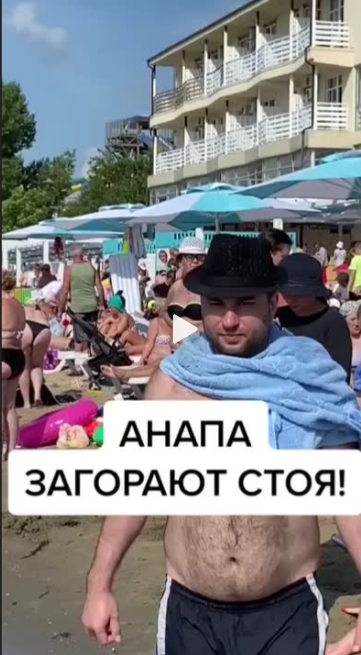

Что это безумство или храбрость в разгар эпидемии, - остаётся за рамками данного проекта. В 2020 году в конце зимы я был в Анапе в командировке, и в те доковидные времена пляжи выглядели так:

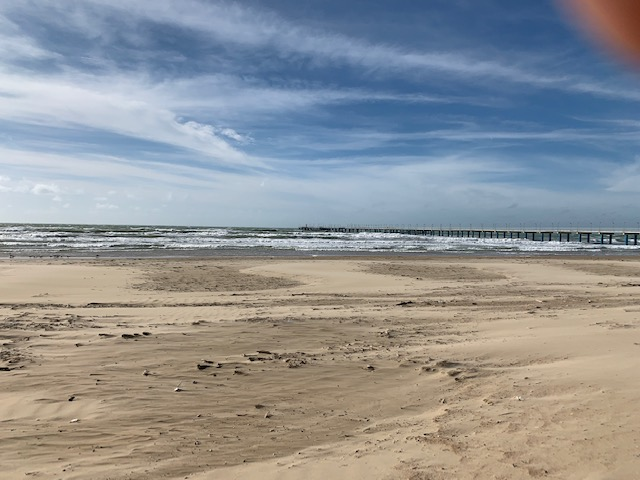

Эта фотография была сделана мной 26 февраля. Как мы видим, отдыхающих нет, можно просто любоваться морем и вдоволь надышаться ветром. Казалось бы, если нет народа, то и нет ажиотажа авиаперевозок в Анапу. Но нет, и в Анапу на Аэробусе А320, и обратно в Шереметьево на Суперджете свободных мест на бортах почти не было. То есть даже зимой это направление востребовано, и значит можно попытаться поиграть в топ-менеджера. Начнём-с.

## Загружаем необходимые библиотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap
import warnings
warnings.simplefilter("ignore")

## Предобработка
Считываем датасет, полученный на основе SQL запроса.

In [2]:
data = pd.read_csv('UpData_Fight_Unit.csv') # Датасет на основе SQL запроса.
display(data)                         # Посмотрим на него.

flight_id departure_airport arrival_airport                model  \
0       136119               AAQ             SVO       Boeing 737-300   
1       136120               AAQ             SVO       Boeing 737-300   
2       136122               AAQ             SVO       Boeing 737-300   
3       136130               AAQ             SVO       Boeing 737-300   
4       136131               AAQ             SVO       Boeing 737-300   
..         ...               ...             ...                  ...   
188     136943               AAQ             EGO  Sukhoi Superjet-100   
189     136951               AAQ             EGO  Sukhoi Superjet-100   
190     136953               AAQ             EGO  Sukhoi Superjet-100   
191     136956               AAQ             EGO  Sukhoi Superjet-100   
192     136961               AAQ             EGO  Sukhoi Superjet-100   

     minutes  pass_count  price_sum  
0      101.0       113.0  1653000.0  
1       99.0       109.0  1605400.0  
2      100.0        97.0  1431000.0  
3       99.0       107.0  1556600.0  
4       99.0       124.0  1812800.0  
..       ...         ...        ...  
188     50.0        94.0   733800.0  
189     49.0        90.0   720600.0  
190     50.0        97.0   765300.0  
191     50.0        96.0   746400.0  
192     49.0        96.0   759000.0  

[193 rows x 7 columns]

Используемые признаки:
* **flight_id** - идентификатор рейса;
* **departure_airport** - аэропорт отправления;
* **arrival_airport** - аэропорт прибытия;
* **model** - модель самолёта;
* **minutes** - длительность полёта в минутах;
* **pass_count** - актуальное количество пассажиров в самолёте;
* **price_sum** - доход от продажи билетов, руб.

Также полезно посмотреть.

In [3]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   flight_id          193 non-null    int64  
 1   departure_airport  193 non-null    object 
 2   arrival_airport    193 non-null    object 
 3   model              193 non-null    object 
 4   minutes            193 non-null    float64
 5   pass_count         180 non-null    float64
 6   price_sum          180 non-null    float64
dtypes: float64(3), int64(1), object(3)
memory usage: 10.7+ KB


flight_id     minutes  pass_count     price_sum
count     193.000000  193.000000  180.000000  1.800000e+02
mean   136540.466321   90.538860  101.950000  1.179647e+06
std       249.389171   62.864684   14.423086  4.811836e+05
min    136119.000000   49.000000   64.000000  5.310000e+05
25%    136320.000000   50.000000   93.000000  7.385250e+05
50%    136534.000000   99.000000   97.000000  1.068850e+06
75%    136768.000000  100.000000  112.250000  1.631950e+06
max    136961.000000  312.000000  130.000000  1.886000e+06

Видно, что присутствуют пропуски по 13 рейсам. Это было видно сразу после выполнения SQL запроса.

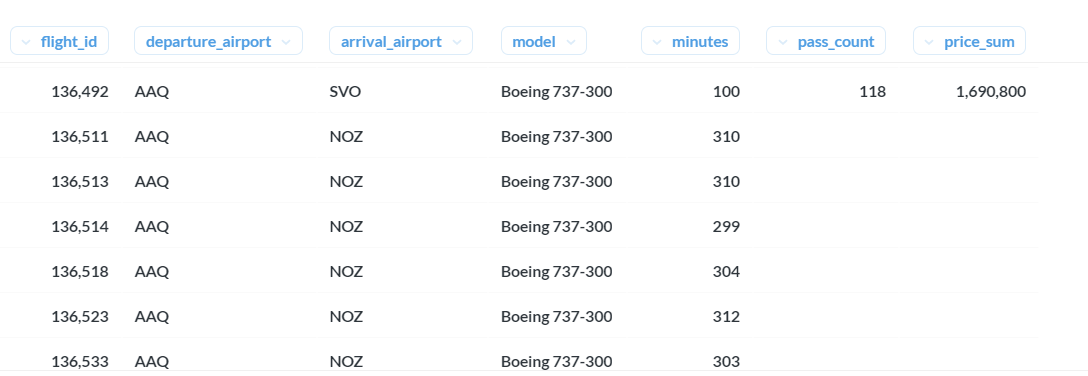

Следует отметить тот факт, что во всех этих рейсах пункт назначения Новокузнецк.

In [4]:
data.isnull().sum() # Убедимся в этом.

flight_id             0
departure_airport     0
arrival_airport       0
model                 0
minutes               0
pass_count           13
price_sum            13
dtype: int64

Выведем их всех на экран, так как на картинке выше всё не поместилось.

In [5]:
data[data.arrival_airport == 'NOZ']

flight_id departure_airport arrival_airport           model  minutes  \
90      136511               AAQ             NOZ  Boeing 737-300    310.0   
91      136513               AAQ             NOZ  Boeing 737-300    310.0   
92      136514               AAQ             NOZ  Boeing 737-300    299.0   
93      136518               AAQ             NOZ  Boeing 737-300    304.0   
94      136523               AAQ             NOZ  Boeing 737-300    312.0   
95      136533               AAQ             NOZ  Boeing 737-300    303.0   
96      136534               AAQ             NOZ  Boeing 737-300    304.0   
97      136540               AAQ             NOZ  Boeing 737-300    307.0   
98      136544               AAQ             NOZ  Boeing 737-300    304.0   
99      136546               AAQ             NOZ  Boeing 737-300    302.0   
100     136560               AAQ             NOZ  Boeing 737-300    305.0   
101     136564               AAQ             NOZ  Boeing 737-300    305.0   
102     136567               AAQ             NOZ  Boeing 737-300    311.0   

     pass_count  price_sum  
90          NaN        NaN  
91          NaN        NaN  
92          NaN        NaN  
93          NaN        NaN  
94          NaN        NaN  
95          NaN        NaN  
96          NaN        NaN  
97          NaN        NaN  
98          NaN        NaN  
99          NaN        NaN  
100         NaN        NaN  
101         NaN        NaN  
102         NaN        NaN

Тот факт, что данная ситуация происходит только для Боинга с пунктом назначения Новокузнецк, заставляет задуматься, что возможно это не обычный пропуск по причине халатного заполенения БД или сбоя, а что-то запланированное.

Отмечу тот факт, что по роду моей деятельности я часто контактирую со специалистами ОКБ Сухого. Между делом я поинтересовался, что это может значить? Оказывается, есть такое понятие как **_слот_**. Это некое временное окно для взлёта/посадки воздушного судна, которое авиакомпания выкупает. Более подробно можно почитать, например, [тут](https://ru.xcv.wiki/wiki/Landing_slot). Цена слота очень высока и компании могут перепродавать их друг другу. Ниже представлена таблица одних из таких покупок для Хитроу (картинка из вышеуказанной ссылки, и за что компанию Virgin так перевели - вопросы к владельцам сайта :)).

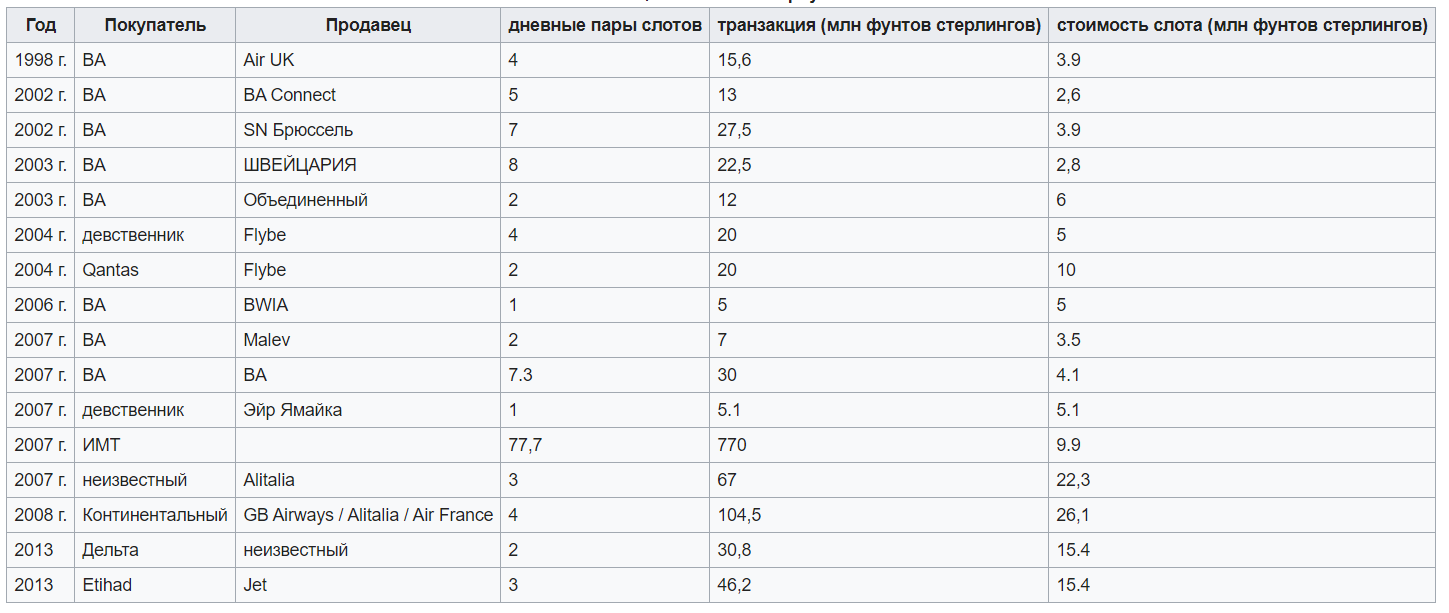

Как видно, суммы очень внушительные. Более того, если авиакомпания не использует выделенные слоты (обычно 80% использования в течение шести месяцев), она может потерять права. Поэтому авиакомпании вынуждены выполнять призрачные или пустые рейсы, чтобы сохранить распределение слотов. Иначе их снова придётся выкупать.

На этом основании я буду считать, что все рейсы Боинга 737-300 в Новокузнецк являются вынужденными рейсами без пассажиров, чтобы не потерять слот. Здесь конечно экономить не получится, с этим придётся мириться и забыть про эти рейсы, поэтому удалим их из датасета.

In [6]:
data = data.dropna();     # Прощай, Новокузнецк..
data = data.reset_index() # Переиндексируем.
del data['index']         # Сносим индексы.
display(data)             # Посмотрим на обновлённый датасет.

flight_id departure_airport arrival_airport                model  \
0       136119               AAQ             SVO       Boeing 737-300   
1       136120               AAQ             SVO       Boeing 737-300   
2       136122               AAQ             SVO       Boeing 737-300   
3       136130               AAQ             SVO       Boeing 737-300   
4       136131               AAQ             SVO       Boeing 737-300   
..         ...               ...             ...                  ...   
175     136943               AAQ             EGO  Sukhoi Superjet-100   
176     136951               AAQ             EGO  Sukhoi Superjet-100   
177     136953               AAQ             EGO  Sukhoi Superjet-100   
178     136956               AAQ             EGO  Sukhoi Superjet-100   
179     136961               AAQ             EGO  Sukhoi Superjet-100   

     minutes  pass_count  price_sum  
0      101.0       113.0  1653000.0  
1       99.0       109.0  1605400.0  
2      100.0        97.0  1431000.0  
3       99.0       107.0  1556600.0  
4       99.0       124.0  1812800.0  
..       ...         ...        ...  
175     50.0        94.0   733800.0  
176     49.0        90.0   720600.0  
177     50.0        97.0   765300.0  
178     50.0        96.0   746400.0  
179     49.0        96.0   759000.0  

[180 rows x 7 columns]

## Дополнительные данные

Поскольку проект называется "Авиарейсы без потерь", следовательно надо будет выяснить причины убытков. Авиакомпания должна не только зарабатывать, но заботиться о своих подчинённых - платить зарплату, разного рода взносы, налоги и так далее. Одним из таких факторов является топливо, которое сложно переоценить. Поэтому для более качественного анализа был подготовлен дополнительный датасет с характеристиками воздушных судов касательно топлива.

In [7]:
plane = pd.read_csv('UpData_Plane.csv')  # Загрузка ЛТХ ВС (лётно-технических характеристик воздушных судов).
display(plane)

model  max_pass_count
0       Boeing 737-300             130
1  Sukhoi Superjet-100              97

Признаки:
* **model** - модель ВС;
* **max_pass_count** - пассажировместимость, чел.

Свойства топлива брались для нормальных условий. Иформация бралась тут: [Wiki](https://ru.wikipedia.org/wiki/Заглавная_страница).

In [8]:
# Обновляем исходный датасет новой информацией по полю craft_model.
data = data.merge(plane, on='model')

In [9]:
# Что получилось?
data.sample(10)

flight_id departure_airport arrival_airport                model  \
51      136327               AAQ             SVO       Boeing 737-300   
104     136649               AAQ             EGO  Sukhoi Superjet-100   
54      136348               AAQ             SVO       Boeing 737-300   
91      136586               AAQ             EGO  Sukhoi Superjet-100   
16      136185               AAQ             SVO       Boeing 737-300   
157     136866               AAQ             EGO  Sukhoi Superjet-100   
148     136827               AAQ             EGO  Sukhoi Superjet-100   
61      136385               AAQ             SVO       Boeing 737-300   
80      136463               AAQ             SVO       Boeing 737-300   
169     136913               AAQ             EGO  Sukhoi Superjet-100   

     minutes  pass_count  price_sum  max_pass_count  
51     100.0       108.0  1543200.0             130  
104     50.0        96.0   759000.0              97  
54     100.0       120.0  1762800.0             130  
91      50.0        96.0   759000.0              97  
16     103.0       104.0  1520000.0             130  
157     50.0        94.0   733800.0              97  
148     51.0        97.0   765300.0              97  
61     100.0       128.0  1861600.0             130  
80      99.0       122.0  1788400.0             130  
169     49.0        90.0   695400.0              97


## Расходы.

С доходами довольно таки всё понятно, это проданные билеты. Пришло поговорить о расходах. На основании материалов сайта http://bricsmagazine.com/ru/articles/ekonomika-poleta известно:

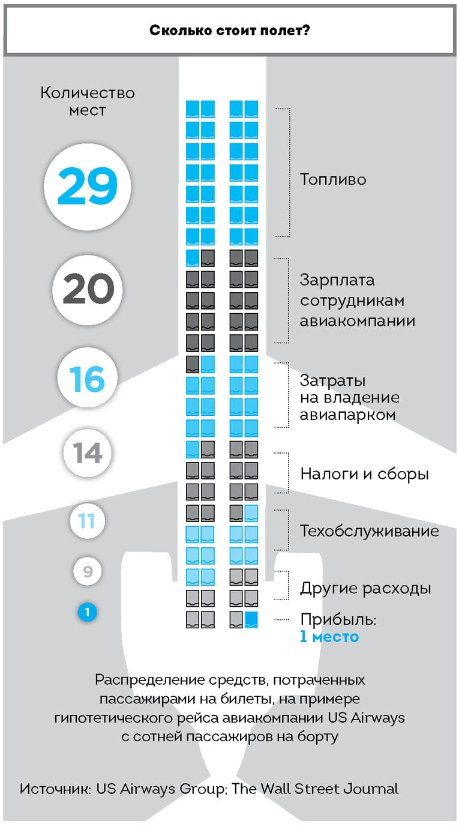

То есть основные расходы таковы:
* 29% - Топливо;
* 20% - Зарплата;
* 16% - Владение авиапарком (лизинг, покупка новых ВС)
* 14% - Налоги и сборы;
* 11% - Техобслуживание;
* 9% - Другие расходы (обеспечение питания например сюда же входит);
* Один процент прибыли?!

Поверим на слово данной информации, так как она была подготовлена на основе серьёзных и уважаемых СМИ. Будем считать, что прибыль действительно составляет 1% от проданных билетов (во что я слабо верю, но куда деваться). Сформируем новый столбец в нашем датасете, согласно представленному выше. Понятное дело, что данный подход применим только для рейсов с пассажирами.

## Прибыль

In [10]:
data["profit"] = 0.01*data["price_sum"]  # Прибыль.
display(data) # Посмотрим на обновленный датасет.

flight_id departure_airport arrival_airport                model  \
0       136119               AAQ             SVO       Boeing 737-300   
1       136120               AAQ             SVO       Boeing 737-300   
2       136122               AAQ             SVO       Boeing 737-300   
3       136130               AAQ             SVO       Boeing 737-300   
4       136131               AAQ             SVO       Boeing 737-300   
..         ...               ...             ...                  ...   
175     136943               AAQ             EGO  Sukhoi Superjet-100   
176     136951               AAQ             EGO  Sukhoi Superjet-100   
177     136953               AAQ             EGO  Sukhoi Superjet-100   
178     136956               AAQ             EGO  Sukhoi Superjet-100   
179     136961               AAQ             EGO  Sukhoi Superjet-100   

     minutes  pass_count  price_sum  max_pass_count   profit  
0      101.0       113.0  1653000.0             130  16530.0  
1       99.0       109.0  1605400.0             130  16054.0  
2      100.0        97.0  1431000.0             130  14310.0  
3       99.0       107.0  1556600.0             130  15566.0  
4       99.0       124.0  1812800.0             130  18128.0  
..       ...         ...        ...             ...      ...  
175     50.0        94.0   733800.0              97   7338.0  
176     49.0        90.0   720600.0              97   7206.0  
177     50.0        97.0   765300.0              97   7653.0  
178     50.0        96.0   746400.0              97   7464.0  
179     49.0        96.0   759000.0              97   7590.0  

[180 rows x 9 columns]

В целом в датасете есть информация о времени полёта, возможно это можно так же использовать для повышения или понижения прибыли? Посмотрим.

In [11]:
data[data.arrival_airport == 'SVO'].minutes.describe()  # Информация по Шереметьево.

count     90.000000
mean      99.966667
std        1.021675
min       98.000000
25%       99.000000
50%      100.000000
75%      100.000000
max      103.000000
Name: minutes, dtype: float64

In [12]:
data[data.arrival_airport == 'EGO'].minutes.describe()  # Информация по Белгороду.

count    90.000000
mean     50.011111
std       0.627004
min      49.000000
25%      50.000000
50%      50.000000
75%      50.000000
max      51.000000
Name: minutes, dtype: float64

Даже грустно стало.. Разница по времени полёта до этих городов почти всегда одна и та же. И я не вижу смысла ухищряться пересчётом прибыли на основе времени данного времени.

## Построение модели рентабельности
Так или иначе рейсы, где заполняемость ВС невысока, скорее всего подлежат взятию на контроль. Предлагаю попробовать добавить ещё один столбец **filling** - доля заполнения ВС.

In [13]:
data['filling'] = data.pass_count / data.max_pass_count  # Вычислим заполняемость ВС.
data.filling.describe()                                  # Определим характеристики данного признака.

count    180.000000
mean       0.902591
std        0.081175
min        0.659794
25%        0.838462
50%        0.907216
75%        0.989691
max        1.000000
Name: filling, dtype: float64

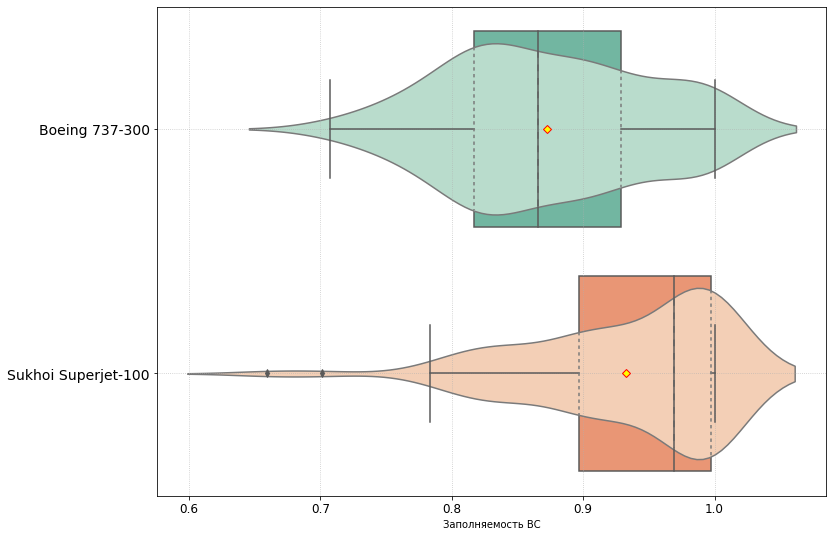

In [14]:
# Построим описательную статистику и плотность распределения
plt.rcParams.update({
        "grid.linestyle"       : "dotted",
        "grid.alpha"           : 0.75,
        "xtick.labelsize"      : 12,
        "ytick.labelsize"      : 14,
})

cols = ['craft_model', 'filling'];
fig, ax = plt.subplots(figsize=(12, 9))

mean_props = dict(marker='D', markeredgecolor='Red',
                  markerfacecolor='Yellow')
sns.boxplot(x="filling", y="model", data=data, palette="Set2",
            showmeans=True, meanprops=mean_props)
sns.violinplot(x=data.filling, y=data.model, width=0.7, palette="Pastel2",
               scale="count", inner='quartile')
#---
ax.grid("both"); ax.set_ylabel(''); ax.set_xlabel('Заполняемость ВС');

Как видно из представлнных графиков, SSJ100 с точки зрения востребованности выигрывает у Боинга. Это можно объяснить тем, что посадочных мест в SSJ100 меньше. Тем не менее, видно, что распределение более вытянутое и имеет два выброса в отличие от распределения Боинга.

Что ж.. Теперь надо обдумать, каким образом выделить рейсы, от которых можно отказаться. Прежде, чем выбрать модель отсева, посмотрим на распределение зависимости прибыли от заполнения салона для обоих типов ВС.

In [15]:
B_data = data[data.model=='Boeing 737-300']      # Выделяем только рейсы с Боингами.
S_data = data[data.model=='Sukhoi Superjet-100'] # Выделяем только рейсы с SSJ100.

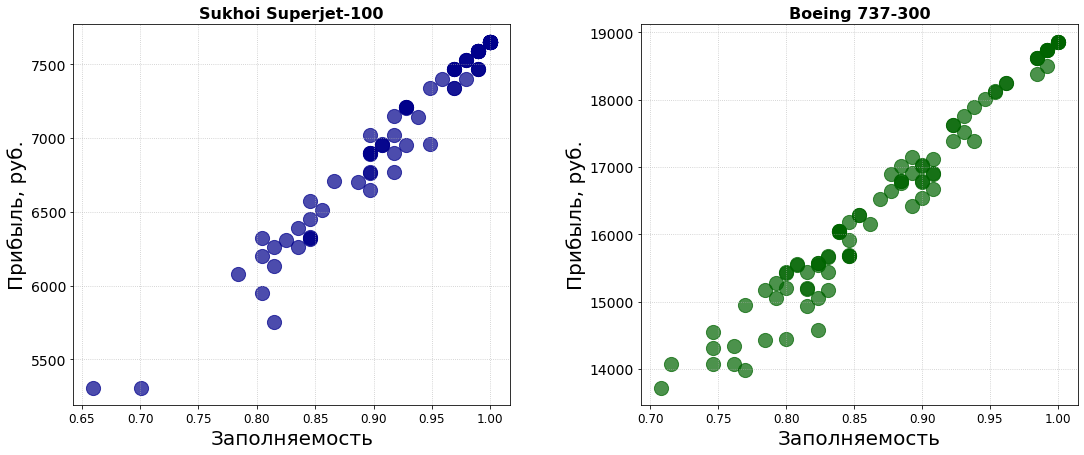

In [16]:
# Строим два графика.
fig, ax = plt.subplots(1, 2, figsize=(18, 7));
fig.subplots_adjust(wspace=0.3)
[axs.grid(axis = 'both') for axs in ax]

# Для SSJ100.
ax[0].set_title('Sukhoi Superjet-100', fontweight = 'bold', fontsize = 16)
ax[0].scatter(S_data.filling, S_data.profit, c='DarkBlue', s=200, cmap='summer', alpha=0.7)
ax[0].set_xlabel('Заполняемость', fontsize=20);
ax[0].set_ylabel('Прибыль, руб.', fontsize=20);

# Для Boeing.
ax[1].set_title('Boeing 737-300', fontweight = 'bold', fontsize = 16)
ax[1].scatter(B_data.filling, B_data.profit, c='DarkGreen', s=200, cmap='summer', alpha=0.7)
ax[1].set_xlabel('Заполняемость', fontsize=20);
ax[1].set_ylabel('Прибыль, руб.', fontsize=20);


Видим, что зависимость прибыли от заполняемости близка к линейной. Разброс можно охарактеризовать динамикой ценообразования топлива. Также сделаем важные замечания по каждому из графиков.

### По SSJ100
Из представленных зависимостей видно, что выбросы для SSJ100 сильно изолированы от общей массы рейсов этого ВС. Естественно, что данные рейсы следует закрыть. Также следует отметить, что существуют рейсы, которые выделяются на остальном фоне, это те, прибыль которых ниже 6 тысяч рублей.

### По Boeing
Здесь сложнее.. Но в целом можно выделить группу рейсов, прибыль которых ниже 15000 рублей..

Тем не менее, доводы о том, какие рейсы будем закрывать, должны быть обоснованы не на каких-либо субъективных или личностых мотивах, а на основе некой модели. Взглянем снова на графики. Мы видим, что множество рейсов в неком смысле разделено на подмножества. Так рейсы для SSJ100 и для Боинга, которые я предложил отменить, располагаются "близко друг от друга". Почему в кавычках? Потому что в данном случае близость я воспринимаю как кучность распределения точек. Также следует отметить, что и остальное подмножество разбито на отдельные группы. В целом для SSJ100 можно выделить 4 таких группы, а для Боинга больше, около 5.
Ввиду того, что датасет имеет некое разбиение, о котором сказано выше, я предлагаю провести кластеризацию множества рейсов на основании данных графиков. Считаю, что лучше сделать 4 кластера для каждого ВС:
* для SSJ100 это вполне естественно;
* для Боинга позволит избежать излишних кластеров;
* дополнительно это позволит урезать большее число рейсов.

Для операции кластеризации я воспользуюсь методом k средних, реализованных в sklearn.cluster классом KMeans. Начнём-с..

In [17]:
# Объекты для кластеризации.
B_kmeans = KMeans(n_clusters = 4) # Для Бонига.
S_kmeans = KMeans(n_clusters = 4) # Для SSJ100.

# Выполняем подгонку для 4 кластеров.
B_kmeans.fit(B_data[['filling', 'profit']])                  # Обучаем для Боинга.
B_y_kmeans = B_kmeans.predict(B_data[['filling', 'profit']]) # Получаем номер кластера.

S_kmeans.fit(S_data[['filling', 'profit']])                  # Обучаем для SSJ100.
S_y_kmeans = S_kmeans.predict(S_data[['filling', 'profit']]) # Получаем номер кластера.

Давайте посмотрим на эти кластеры.

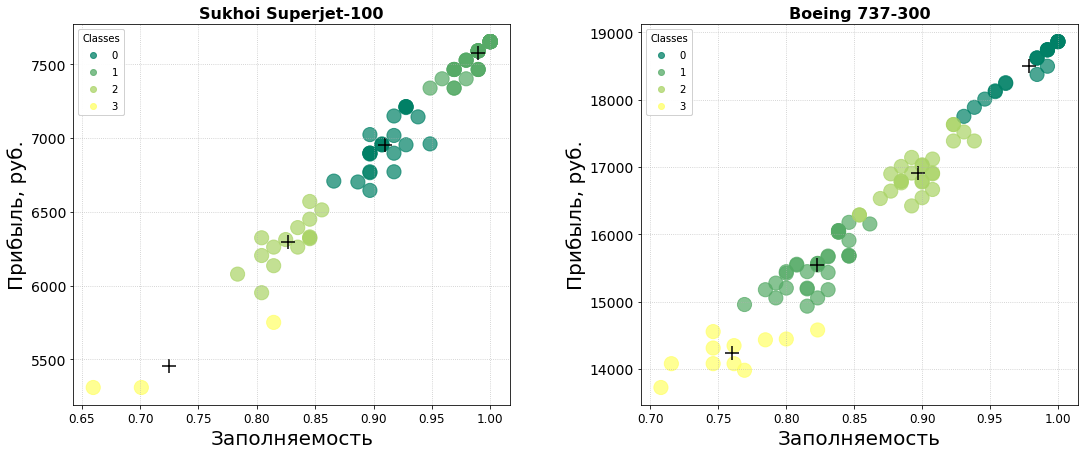

In [18]:
# Строим два графика.
fig, ax = plt.subplots(1, 2, figsize=(18, 7));
fig.subplots_adjust(wspace=0.3)
[axs.grid(axis = 'both') for axs in ax]

# Для SSJ100.
ax[0].set_title('Sukhoi Superjet-100', fontweight = 'bold', fontsize = 16)
S_scatter = ax[0].scatter(S_data.filling, S_data.profit, c=S_y_kmeans, s=200, cmap='summer', alpha=0.7)
ax[0].set_xlabel('Заполняемость', fontsize=20);
ax[0].set_ylabel('Прибыль, руб.', fontsize=20);
S_legend = ax[0].legend(*S_scatter.legend_elements(), loc="upper left", title="Classes")
ax[0].add_artist(S_legend);
S_data['Class'] = S_y_kmeans
# Посмотрим на центры кластеров
S_centers = S_kmeans.cluster_centers_
ax[0].scatter(S_centers[:,0], S_centers[:,1], c='black', s=200, marker ='+')

# Для Boeing.
ax[1].set_title('Boeing 737-300', fontweight = 'bold', fontsize = 16)
B_scatter = ax[1].scatter(B_data.filling, B_data.profit, c=B_y_kmeans, s=200, cmap='summer', alpha=0.7)
ax[1].set_xlabel('Заполняемость', fontsize=20);
ax[1].set_ylabel('Прибыль, руб.', fontsize=20);
B_legend = ax[1].legend(*B_scatter.legend_elements(), loc="upper left", title="Classes")
ax[1].add_artist(B_legend);
B_data['Class'] = B_y_kmeans
# Посмотрим на центры кластеров
B_centers = B_kmeans.cluster_centers_
ax[1].scatter(B_centers[:,0], B_centers[:,1], c='black', s=200, marker ='+');

**Кластеризация коварна, поскольку в её алгоритмах используется рандом. Поэтому: номера классов могут не совпадать от запуска к запуску, но кластеры всегда остаются неизменными! Поэтому надо быть аккуратным и уметь обходить данные трудности.**

In [19]:
# Обходим трудности
S_off = int(S_kmeans.predict(np.array([[0.7, 5000]])))   # Наверняка попадём в нужный кластер (на закрытие)
B_off = int(B_kmeans.predict(np.array([[0.7, 14000]])))  # Наверняка попадём в нужный кластер (на закрытие)
print(f'Исключаемый класс для SSJ100 - {S_off},\nИсключаемый класс для Боинга - {B_off}.')

Исключаемый класс для SSJ100 - 3,
Исключаемый класс для Боинга - 3.


Как видно, операция кластеризации довольно ожидаемо разбила наши множества. Все рейсы отнесённые к классу №3 (в данном запуске) следует исключить. Символом "+" обозначены центры кластеров.

Предлагаю видоизменить классификацию: если исключаем Class = 0, если оставляем Class = 1.

In [20]:
B_data['Class'] = B_data['Class'].apply(lambda x: 0 if x==B_off else 1) # Для Боинга.
S_data['Class'] = S_data['Class'].apply(lambda x: 0 if x==S_off else 1) # Для SSJ100.

Предлагаю посмотреть на границы раздела подмножеств рейсов для каждого ВС.

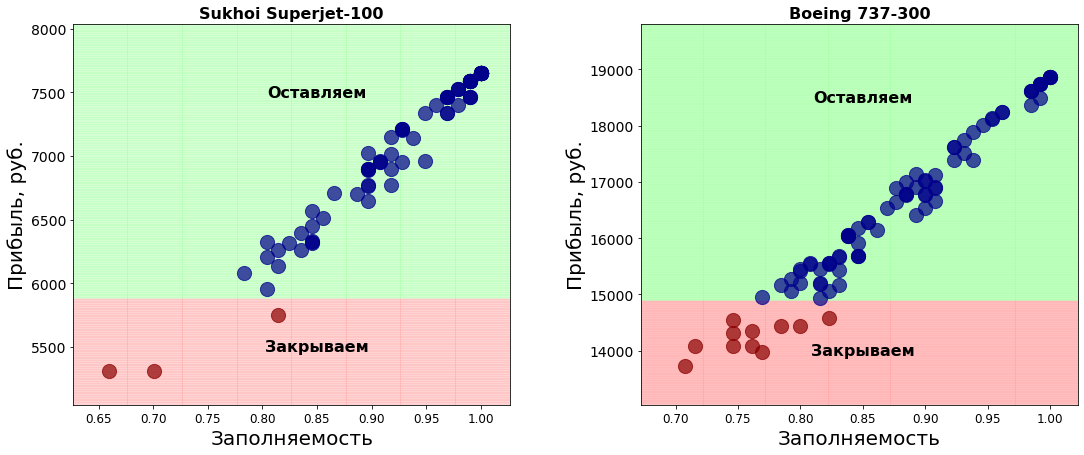

In [21]:
# Лямбда функции для борьбы с рандомайзом присвоения классов
B_f = lambda x: 0 if x == B_off else 1
S_f = lambda x: 0 if x == S_off else 1

# Строим два графика.
fig, ax = plt.subplots(1, 2, figsize=(18, 7));
fig.subplots_adjust(wspace=0.3)
[axs.grid(axis = 'both') for axs in ax]

# Построим границу раздела.
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])   # Цветовая палитра.
h = 0.05  # Шаг по сетке.

# Для SSJ100.
xx, yy = np.meshgrid(np.arange(0.95*S_data.filling.min(), 1.05*S_data.filling.max(), h),
                     np.arange(0.95*S_data.profit.min(), 1.05*S_data.profit.max(), 100*h))
S_Z = S_kmeans.predict(np.c_[xx.ravel(),yy.ravel()])
# Боремся с рандомайзом названий
for i in range(0, len(S_Z)):
    S_Z[i] = S_f(S_Z[i])
S_Z = S_Z.reshape(xx.shape)
ax[0].pcolormesh(xx, yy, S_Z, cmap=cmap_light, alpha=0.3)

# Для Boeing.
xx, yy = np.meshgrid(np.arange(0.95*B_data.filling.min(), 1.05*B_data.filling.max(), h),
                     np.arange(0.95*B_data.profit.min(), 1.05*B_data.profit.max(), 100*h))
B_Z = B_kmeans.predict(np.c_[xx.ravel(),yy.ravel()])
# Боремся с рандомайзом названий
for i in range(0, len(B_Z)):
    B_Z[i] = B_f(B_Z[i])
B_Z = B_Z.reshape(xx.shape)
ax[1].pcolormesh(xx, yy, B_Z, cmap=cmap_light, alpha=0.3)

# Строим точки
# Для SSJ100.
ax[0].set_title('Sukhoi Superjet-100', fontweight = 'bold', fontsize = 16)
# Те, кого оставляем.
S_data_1 = S_data[S_data.Class == 1]
ax[0].scatter(S_data_1.filling, S_data_1.profit, c='DarkBlue', s=200, cmap='summer', alpha=0.7)
ax[0].text(s = 'Оставляем', x = 0.85, y = 7500, ha = 'center', va = 'center',
           color ='black', fontsize = 16, fontweight = 'bold')

# Которые в расход.
S_data_0 = S_data[S_data.Class == 0]
ax[0].scatter(S_data_0.filling, S_data_0.profit, c='DarkRed', s=200, cmap='summer', alpha=0.7)
ax[0].text(s = 'Закрываем', x = 0.85, y = 5500, ha = 'center', va = 'center',
           color ='black', fontsize = 16, fontweight = 'bold')
ax[0].set_xlabel('Заполняемость', fontsize=20);
ax[0].set_ylabel('Прибыль, руб.', fontsize=20);

# Для Boeing.
ax[1].set_title('Boeing 737-300', fontweight = 'bold', fontsize = 16)
# Те, кого оставляем.
B_data_1 = B_data[B_data.Class == 1]
ax[1].scatter(B_data_1.filling, B_data_1.profit, c='DarkBlue', s=200, cmap='summer', alpha=0.7)
ax[1].text(s = 'Оставляем', x = 0.85, y = 18500, ha = 'center', va = 'center',
           color ='black', fontsize = 16, fontweight = 'bold')

# Увы..
B_data_0 = B_data[B_data.Class == 0]
ax[1].scatter(B_data_0.filling, B_data_0.profit, c='DarkRed', s=200, cmap='summer', alpha=0.7)
ax[1].text(s = 'Закрываем', x = 0.85, y = 14000, ha = 'center', va = 'center',
           color ='black', fontsize = 16, fontweight = 'bold')
ax[1].set_xlabel('Заполняемость', fontsize=20);
ax[1].set_ylabel('Прибыль, руб.', fontsize=20);

Что имеем? Видим, что граница раздела для конкретно этого датасета - прямая. Это даёт повод предположить, что главным фактором, влиящим на отсев рейсов, является прибыль. Так для SSJ100 границей рентабельности является ~5900 рублей, а для Боинга ~14900 рублей.
Подготовим обновленный датасет и датасет с рейсами, подлежащими закрытию.

In [22]:
new_data = pd.concat([S_data_1, B_data_1]) # Новый датасет.
new_data = new_data.reset_index()          # Переиндексируем.
del new_data['index']                      # Сносим индексы.

In [23]:
# Посмотрим на обновлённый датасет.
display(new_data)
new_data.profit.describe()

flight_id departure_airport arrival_airport                model  \
0       136571               AAQ             EGO  Sukhoi Superjet-100   
1       136586               AAQ             EGO  Sukhoi Superjet-100   
2       136592               AAQ             EGO  Sukhoi Superjet-100   
3       136600               AAQ             EGO  Sukhoi Superjet-100   
4       136605               AAQ             EGO  Sukhoi Superjet-100   
..         ...               ...             ...                  ...   
161     136479               AAQ             SVO       Boeing 737-300   
162     136485               AAQ             SVO       Boeing 737-300   
163     136486               AAQ             SVO       Boeing 737-300   
164     136491               AAQ             SVO       Boeing 737-300   
165     136492               AAQ             SVO       Boeing 737-300   

     minutes  pass_count  price_sum  max_pass_count   profit   filling  Class  
0       50.0        95.0   752700.0              97   7527.0  0.979381      1  
1       50.0        96.0   759000.0              97   7590.0  0.989691      1  
2       50.0        89.0   677100.0              97   6771.0  0.917526      1  
3       50.0        97.0   765300.0              97   7653.0  1.000000      1  
4       51.0        97.0   765300.0              97   7653.0  1.000000      1  
..       ...         ...        ...             ...      ...       ...    ...  
161     99.0       122.0  1738400.0             130  17384.0  0.938462      1  
162    100.0       106.0  1520000.0             130  15200.0  0.815385      1  
163    101.0       107.0  1505400.0             130  15054.0  0.823077      1  
164    101.0       103.0  1505400.0             130  15054.0  0.792308      1  
165    100.0       118.0  1690800.0             130  16908.0  0.907692      1  

[166 rows x 11 columns]

count      166.000000
mean     11749.349398
std       4897.275274
min       5952.000000
25%       7353.750000
50%       7653.000000
75%      16615.500000
max      18860.000000
Name: profit, dtype: float64

Видим, что осталось 166 рейсов, 14 были закрыты. Средняя прибыль составляет около 12000 рублей. Минимальная - почти 6000 рублей, а максимальная почти 19000 рублей. Негусто, но это согласно модели, где прибыль 1% от проданных билетов.

In [24]:
# А теперь аналогично сделаем для отменённых рейсов.
off_data = pd.concat([S_data_0, B_data_0]) # Датасет отменённых рейсов.
off_data = off_data.reset_index()          # Переиндексируем.
del off_data['index']                      # Сносим индексы.
display(off_data)                          # Посмотрим на них.

flight_id departure_airport arrival_airport                model  minutes  \
0      136642               AAQ             EGO  Sukhoi Superjet-100     49.0   
1      136807               AAQ             EGO  Sukhoi Superjet-100     50.0   
2      136844               AAQ             EGO  Sukhoi Superjet-100     50.0   
3      136122               AAQ             SVO       Boeing 737-300    100.0   
4      136178               AAQ             SVO       Boeing 737-300     99.0   
5      136204               AAQ             SVO       Boeing 737-300    100.0   
6      136250               AAQ             SVO       Boeing 737-300    101.0   
7      136253               AAQ             SVO       Boeing 737-300     98.0   
8      136306               AAQ             SVO       Boeing 737-300    100.0   
9      136352               AAQ             SVO       Boeing 737-300    100.0   
10     136360               AAQ             SVO       Boeing 737-300    100.0   
11     136397               AAQ             SVO       Boeing 737-300    101.0   
12     136418               AAQ             SVO       Boeing 737-300    100.0   
13     136464               AAQ             SVO       Boeing 737-300    100.0   

    pass_count  price_sum  max_pass_count   profit   filling  Class  
0         64.0   531000.0              97   5310.0  0.659794      0  
1         68.0   531000.0              97   5310.0  0.701031      0  
2         79.0   575100.0              97   5751.0  0.814433      0  
3         97.0  1431000.0             130  14310.0  0.746154      0  
4         99.0  1434600.0             130  14346.0  0.761538      0  
5        107.0  1457800.0             130  14578.0  0.823077      0  
6         99.0  1407800.0             130  14078.0  0.761538      0  
7         93.0  1407800.0             130  14078.0  0.715385      0  
8        102.0  1443200.0             130  14432.0  0.784615      0  
9         92.0  1372400.0             130  13724.0  0.707692      0  
10        97.0  1455400.0             130  14554.0  0.746154      0  
11       104.0  1444400.0             130  14444.0  0.800000      0  
12        97.0  1407800.0             130  14078.0  0.746154      0  
13       100.0  1398000.0             130  13980.0  0.769231      0

## Выводы

В ходе работы построена модель рентабельных рейсов из Анапы. В качестве признака рентабельности авиа рейса можно испльзовать пороговое значение выручки для каждого типа ВС. Модель определения рентабельности была создана на основе алгоритмов кластеризации, реализованных в библиотеке SсikitLearn. Выбор количества кластеров диктовался характером группировки подмножеств рейсов относительно зависимости прибыли от заполнения.
В том случае, если потребуется вычислить рентабельность любого другого рейса на данной обученной модели, следует вызвать следующий код:
* например, **S_kmeans.predict(np.array([0.9, 9000]))** - для SSJ100;
* например, **B_kmeans.predict(np.array([0.9, 18000]))** - для Боинга.

К достоинствам кластеризации следует отнести простоту применения и проработанность теоретических исследований. Из минусов кластеризации можно выделить непостоянство распределения классов, то есть, в первый раз можно запустить один набор точек будет принадлежать 1 классу, а при втором - уже может 2 классу. Это надо учитывать.

Определены убыточные рейсы, которые предлагаю закрыть. Также выявлены вынужденные рейсы ввиду правил предоставления слотов.

## P.S.

Большое Вам спасибо, что дали мне второй шанс. Для меня это очень важно в данный момент. Надеюсь, я не разочаровал Вас.
Ещё раз спасибо!